In [14]:
import re
import pandas as pd
from typing import List, Union
import ast


def calculate_accuracy(true_answers, pred_answers):
    correct = 0
    total = len(true_answers)
    def extract_answer(text):
        
        # Match "the answer is" or "answer" followed by any text
        match = re.search(r"(?:the answer is|answer)(?:\s*:?\s*)(.+)", text, re.IGNORECASE) #([^.]+)(?:\.|$)"
        if match:
                text = match.group(1).strip()
                # Check if the text begins with "yes" or "no" and is longer than one word
        yes_no_match = re.match(r'^(yes|no)\b', text, re.IGNORECASE)
        if yes_no_match:
                text= yes_no_match.group(1).lower()
        return text
    

    def normalize_answer(answer):
        answer = extract_answer(answer)
        if isinstance(answer, str):
        # Then, try to evaluate if it's a string representation of a list
            try:
                lst = ast.literal_eval(answer)
            # Join list elements into a single string, remove special characters, and strip
                return [re.sub(r'[^\w\s]', ' ', ','.join(str(item) for item in lst)).strip().lower()]
            except:
                pass

        if isinstance(answer, list):
           return [re.sub(r'[^\w\s]', ' ', str(item)).strip().lower() for item in answer]
        else:
           return [re.sub(r'[^\w\s]', ' ', str(answer)).strip().lower()]
    
    for true, pred in zip(true_answers, pred_answers):
        if pd.isna(true) or pd.isna(pred):
            total -= 1  # Skip this pair if either is NaN
            continue

        true_set = set(normalize_answer(true))
        pred_set = set(normalize_answer(pred))

        if len(true_set) > 1:  # Multiple correct answers
            if true_set == pred_set:
                correct += 1  # Full match
            # elif true_set.intersection(pred_set):
            #     correct += 0.5  # Partial match
        else:  # Single correct answer
            if true_set == pred_set:
                correct += 1

    return correct / total if total > 0 else 0
try:
    df_results = pd.read_csv('7_models_Base_prompt_300.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        df_results = pd.read_csv('7_models_Base_prompt_300.csv', encoding='latin1')
    except UnicodeDecodeError:
        try:
            df_results = pd.read_csv('7_models_Base_prompt_300.csv', encoding='cp1252')
        except UnicodeDecodeError as e:
            print(f"Unable to decode the file with utf-8, latin1, or cp1252 encodings: {e}")
            raise
models = ["ollama/gemma:2b","ollama/phi3:mini","ollama/qwen:4b","ollama/openchat", "ollama/mistral", "ollama/llama3","llama70B"]
# models = ["ollama/gemma","ollama/openchat", "ollama/mistral", "ollama/llama3"]
# metrics = {}
# df_results = pd.read_csv('Base.csv')

for model in models:
    df_results[f'{model}_accuracy'] = df_results.apply(lambda row: calculate_accuracy([row['Answer']], [row[model]]), axis=1)
    metrics[model] = df_results[f'{model}_accuracy'].mean()

# Print the results
for model, accuracy in metrics.items():
    print(f"Model: {model}")
    print(f" Mean Accuracy: {accuracy}")

# Optionally, save the updated DataFrame back to CSV
df_results.to_csv('accuracy.csv', index=False)

accuracy_by_qtype = df_results.groupby('Q_type')[[f'{model}_accuracy' for model in models]].mean().reset_index()

# Print accuracy by Q_type for each model
print("Accuracy by Q_type for each model:")
for model in models:
    print(f"\n{model}:")
    for _, row in accuracy_by_qtype.iterrows():
        q_type = row['Q_type']
        accuracy = row[f'{model}_accuracy']
        print(f"  {q_type}: {accuracy:.4f}")

# Print overall metrics
print("\nOverall metrics:")
for model, accuracy in metrics.items():
    print(f"{model}: {accuracy:.4f}")
# Melt the dataframe for easier plotting with Seaborn
melted_df = accuracy_by_qtype.melt(id_vars='Q_type', var_name='Model', value_name='Accuracy')

# Plot the data
plt.figure(figsize=(15, 8))
sns.barplot(data=melted_df, x='Q_type', y='Accuracy', hue='Model')
plt.title('Base Prompt: Model Accuracy by Question Type', fontsize=16)
plt.xlabel('Question Type', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Model: ollama/gemma
 Mean Accuracy: 0.3708791208791209
Model: ollama/openchat
 Mean Accuracy: 0.44329896907216493
Model: ollama/mistral
 Mean Accuracy: 0.38144329896907214
Model: ollama/llama3
 Mean Accuracy: 0.45017182130584193
Model: ollama/gemma:2b
 Mean Accuracy: 0.29553264604810997
Model: ollama/phi3:mini
 Mean Accuracy: 0.3024054982817869
Model: ollama/qwen:4b
 Mean Accuracy: 0.41580756013745707
Model: llama70B
 Mean Accuracy: 0.5738831615120275
Accuracy by Q_type for each model:

ollama/gemma:2b:
  CO: 0.2206
  FB: 0.3514
  FR: 0.0635
  YN: 0.4767

ollama/phi3:mini:
  CO: 0.1029
  FB: 0.3108
  FR: 0.1587
  YN: 0.5581

ollama/qwen:4b:
  CO: 0.4118
  FB: 0.4730
  FR: 0.2222
  YN: 0.5116

ollama/openchat:
  CO: 0.3971
  FB: 0.5541
  FR: 0.0952
  YN: 0.6395

ollama/mistral:
  CO: 0.3824
  FB: 0.4730
  FR: 0.0476
  YN: 0.5465

ollama/llama3:
  CO: 0.3382
  FB: 0.5135
  FR: 0.2222
  YN: 0.6512

llama70B:
  CO: 0.5000
  FB: 0.7568
  FR: 0.2698
  YN: 0.6977

Overall metrics:
ollama/gemm

NameError: name 'plt' is not defined

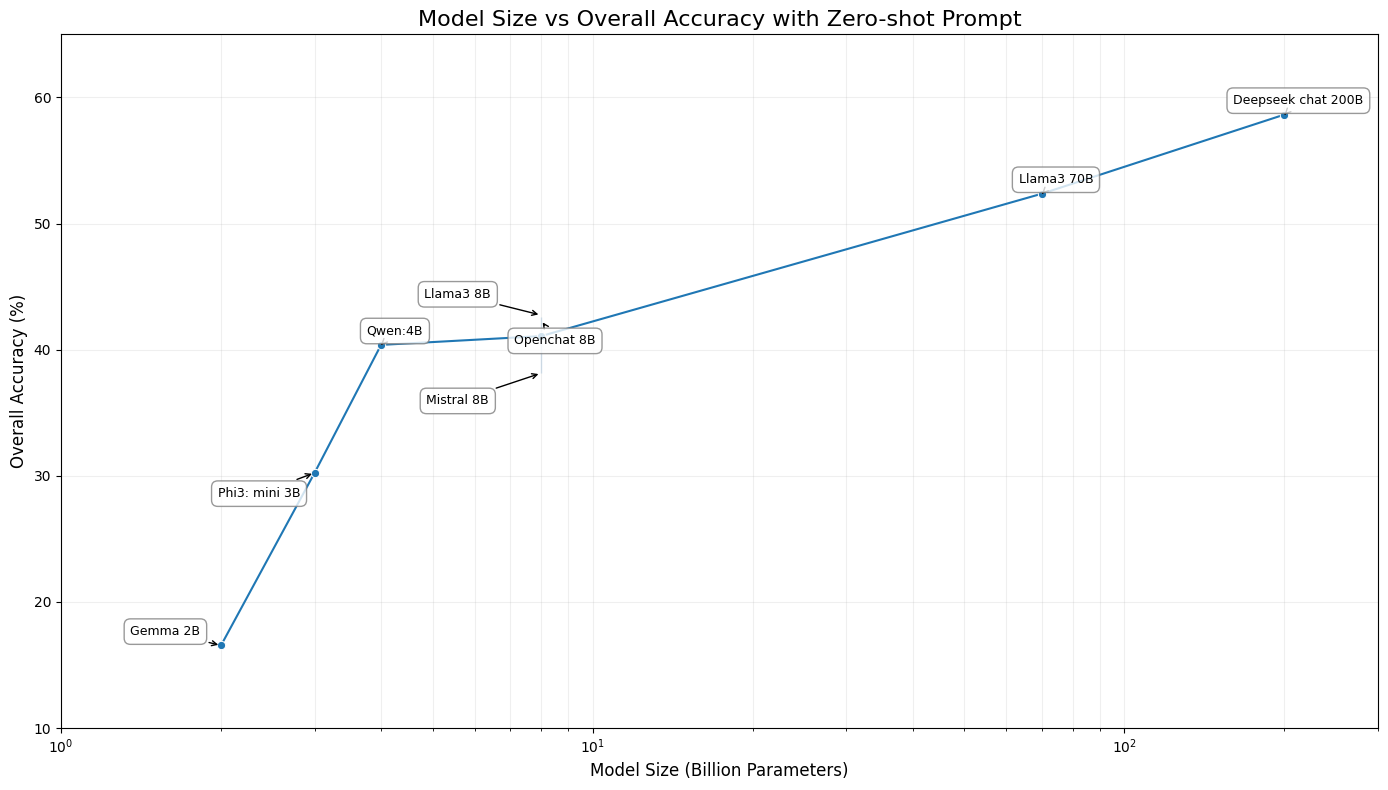

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for overall metrics and model sizes
data = {
    'Model': ['Gemma 2B', 'Phi3: mini 3B', 'Qwen:4B', 'Openchat 8B', 'Mistral 8B', 'Llama3 8B', 'Llama3 70B', 'Deepseek chat 200B'],
    'Size (B)': [2, 3, 4, 8, 8, 8, 70, 200],
    'Accuracy': [16.55, 30.24, 40.38, 42.35, 38.14, 42.74, 52.37, 58.64]
}

df = pd.DataFrame(data)

# Create the line plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x='Size (B)', y='Accuracy', marker='o')

# Custom offsets for each point to avoid overlapping
offsets = [(-40, 10), (-40, -15), (10, 10), (10, -15), (-60, -20), (-60, 15), (10, 10), (10, 10)]

# Annotate each point with the model name
for i, row in df.iterrows():
    plt.annotate(row['Model'], (row['Size (B)'], row['Accuracy']), 
                 xytext=offsets[i], textcoords='offset points',
                 fontsize=9, ha='center', va='center',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.title('Model Size vs Overall Accuracy with Zero-shot Prompt', fontsize=16)
plt.xlabel('Model Size (Billion Parameters)', fontsize=12)
plt.ylabel('Overall Accuracy (%)', fontsize=12)
plt.xscale('log')  # Use log scale for x-axis due to large range
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlim(1, 300)  # Adjust x-axis limits for better visualization
plt.ylim(10, 65)  # Adjust y-axis limits for better visualization
plt.tight_layout()
plt.show()

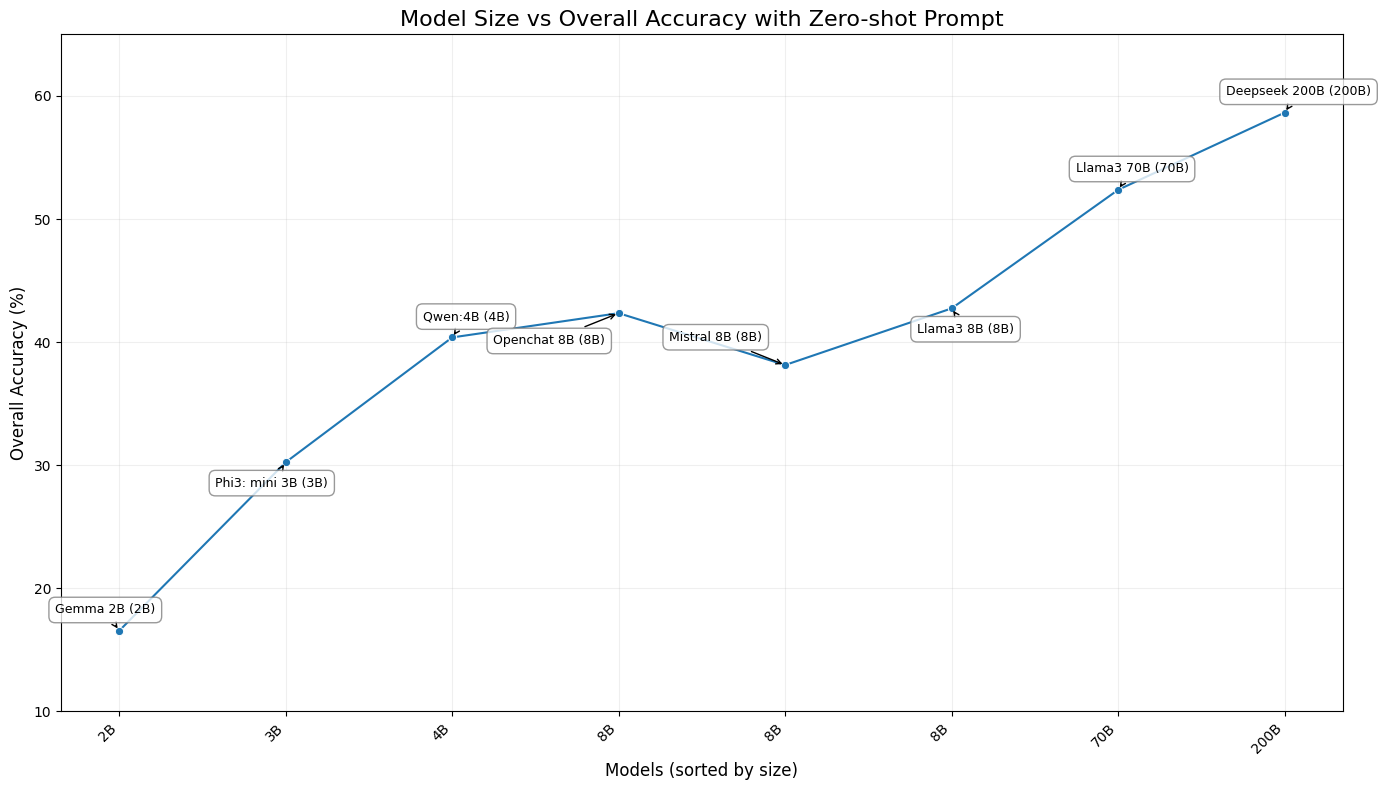

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for overall metrics and model sizes
data = {
    'Model': ['Gemma 2B', 'Phi3: mini 3B', 'Qwen:4B', 'Openchat 8B', 'Mistral 8B', 'Llama3 8B', 'Llama3 70B', 'Deepseek 200B'],
    'Size (B)': [2, 3, 4, 8, 8, 8, 70, 200],
    'Accuracy': [16.55, 30.24, 40.38, 42.35, 38.14, 42.74, 52.37, 58.64]
}

df = pd.DataFrame(data)

# Sort the dataframe by Size
df = df.sort_values('Size (B)')

# Create the line plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x=range(len(df)), y='Accuracy', marker='o')

# Custom offsets for each point to avoid overlapping
offsets = [(-10, 15), (-10, -15), (10, 15), (-50, -20), (-50, 20), (10, -15), (10, 15), (10, 15)]

# Annotate each point with the model name
for i, row in df.iterrows():
    plt.annotate(f"{row['Model']} ({row['Size (B)']}B)", 
                 (i, row['Accuracy']), 
                 xytext=offsets[i], textcoords='offset points',
                 fontsize=9, ha='center', va='center',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.title('Model Size vs Overall Accuracy with Zero-shot Prompt', fontsize=16)
plt.xlabel('Models (sorted by size)', fontsize=12)
plt.ylabel('Overall Accuracy (%)', fontsize=12)
plt.xticks(range(len(df)), [f"{size}B" for size in df['Size (B)']], rotation=45, ha='right')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.ylim(10, 65)  # Adjust y-axis limits for better visualization
plt.tight_layout()
plt.show()

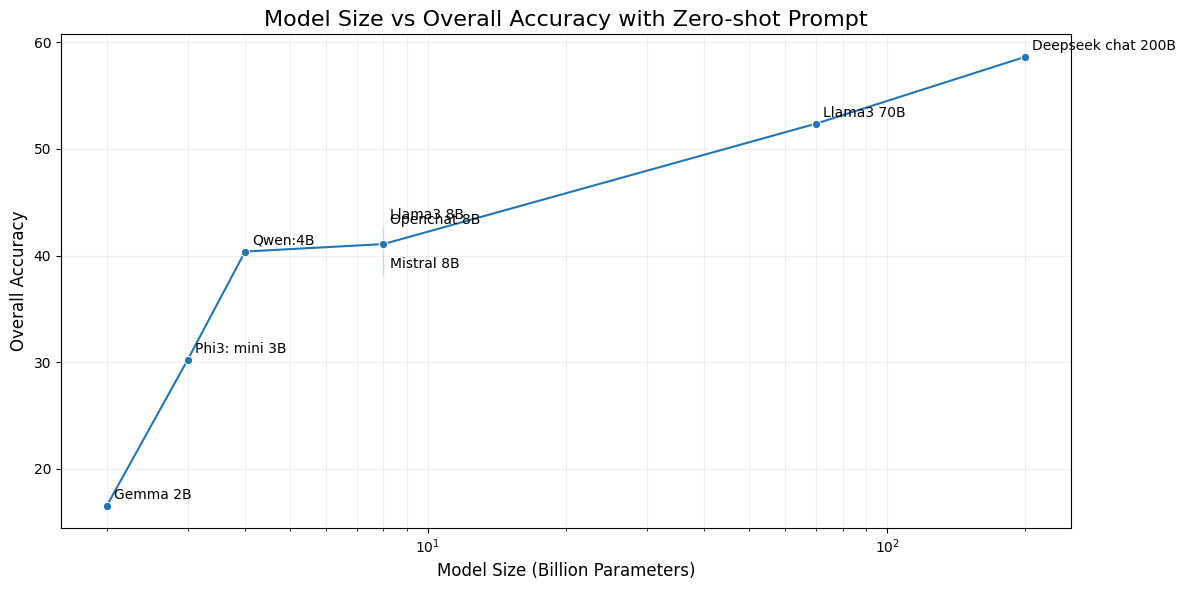

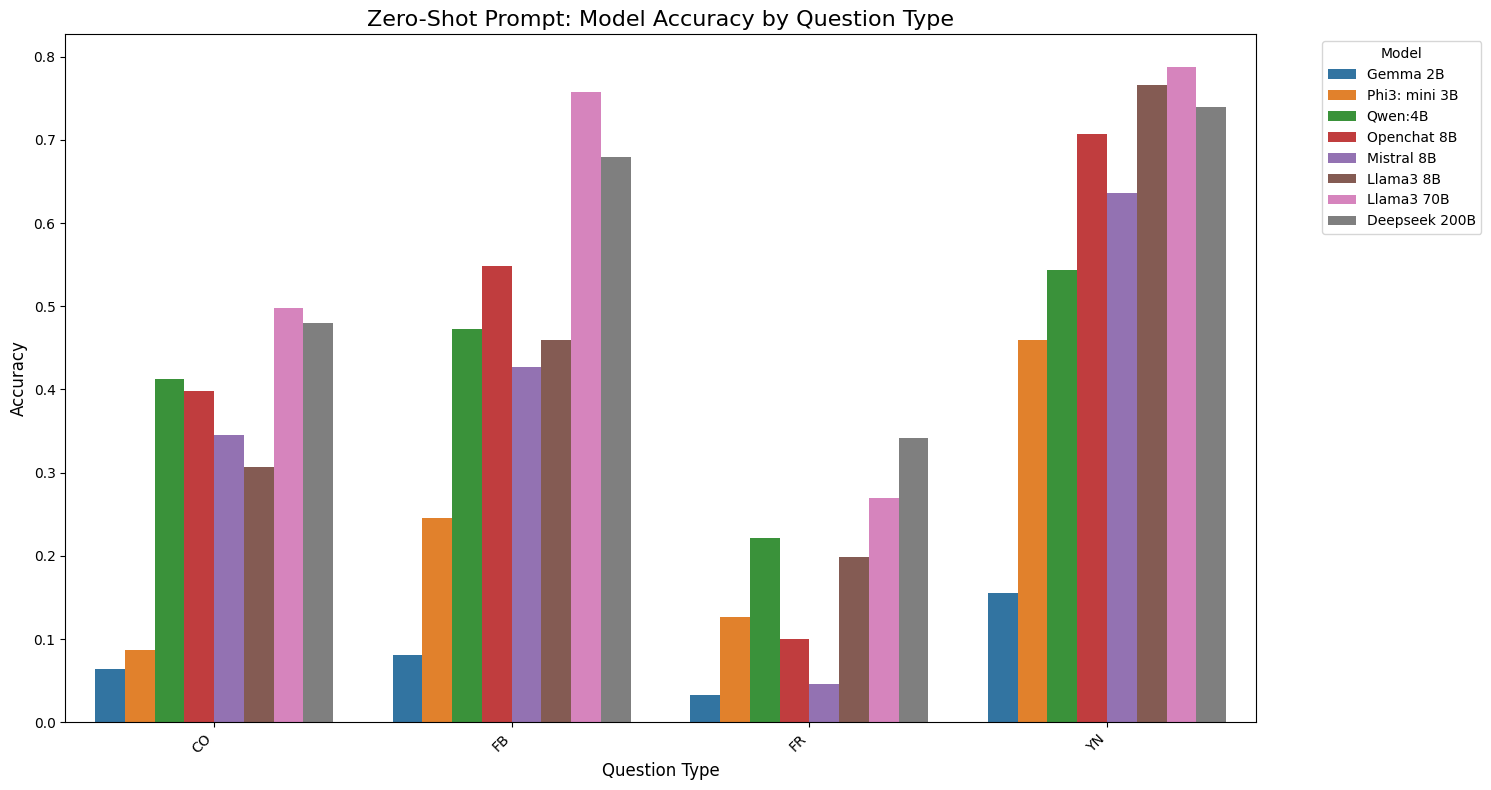

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for overall metrics and model sizes
data = {
    'Model': ['Gemma 2B', 'Phi3: mini 3B', 'Qwen:4B', 'Openchat 8B', 'Mistral 8B', 'Llama3 8B', 'Llama3 70B', 'Deepseek chat 200B'],
    'Size (B)': [2, 3, 4, 8, 8, 8, 70, 200],
   'Accuracy': [16.55, 30.24, 40.38, 42.35, 38.14, 42.74, 52.37, 58.64]
}

df = pd.DataFrame(data)

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Size (B)', y='Accuracy', marker='o')

# Annotate each point with the model name
for i, row in df.iterrows():
    plt.annotate(row['Model'], (row['Size (B)'], row['Accuracy']), 
                 xytext=(5, 5), textcoords='offset points')

plt.title('Model Size vs Overall Accuracy with Zero-shot Prompt', fontsize=16)
plt.xlabel('Model Size (Billion Parameters)', fontsize=12)
plt.ylabel('Overall Accuracy', fontsize=12)
plt.xscale('log')  # Use log scale for x-axis due to large range
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()


# Data for question type accuracies
data_qtype = {
    'Model': ['Gemma 2B', 'Phi3: mini 3B', 'Qwen:4B', 'Openchat 8B', 'Mistral 8B', 'Llama3 8B', 'Llama3 70B', 'Deepseek 200B'],
"CO": [0.0645, 0.0871, 0.4124, 0.3983, 0.3454, 0.3063, 0.4983, 0.4799],
"FB": [0.0806, 0.2454, 0.4727, 0.5479, 0.427, 0.4594, 0.7577, 0.68],
"FR": [0.0322, 0.1267, 0.2213, 0.0996, 0.0454, 0.1982, 0.2692, 0.342],
"YN": [0.1558, 0.4592, 0.5431, 0.7072, 0.6359, 0.7657, 0.7875, 0.7399],
}


df_qtype = pd.DataFrame(data_qtype)

# Melt the DataFrame
melted_df = pd.melt(df_qtype, id_vars=['Model'], var_name='Q_type', value_name='Accuracy')

# Plot the data
plt.figure(figsize=(15, 8))
sns.barplot(data=melted_df, x='Q_type', y='Accuracy', hue='Model')
plt.title('Zero-Shot Prompt: Model Accuracy by Question Type', fontsize=16)
plt.xlabel('Question Type', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
Accuracy by Q_type for each model:

ollama/gemma:2b:
  CO: 0.2206
  FB: 0.3514
  FR: 0.0635
  YN: 0.4767

ollama/phi3:mini:
  CO: 0.1029
  FB: 0.3108
  FR: 0.1587
  YN: 0.5581

ollama/qwen:4b:
  CO: 0.4118
  FB: 0.4730
  FR: 0.2222
  YN: 0.5116

ollama/openchat:
  CO: 0.3971
  FB: 0.5541
  FR: 0.0952
  YN: 0.6395

ollama/mistral:
  CO: 0.3824
  FB: 0.4730
  FR: 0.0476
  YN: 0.5465

ollama/llama3:
  CO: 0.3382
  FB: 0.5135
  FR: 0.2222
  YN: 0.6512

llama70B:
  CO: 0.5000
  FB: 0.7568
  FR: 0.2698
  YN: 0.6977

Overall metrics:Base
ollama/gemma:2b: 0.2955
ollama/phi3:mini: 0.3024
ollama/qwen:4b: 0.4158
ollama/openchat: 0.4433
ollama/mistral: 0.3814
ollama/llama3: 0.4502
llama70B: 0.5739

Overall metrics: Visual
ollama/gemma:2b: 0.0344
ollama/phi3:mini: 0.3643
ollama/qwen:4b: 0.3093
ollama/openchat: 0.4192
ollama/mistral: 0.3814
ollama/llama3: 0.4330
llama70B: 0.5739

Model: ollama/gemma:2b
 Mean Accuracy: 0.03436426116838488
Model: ollama/phi3:mini
 Mean Accuracy: 0.3642611683848797
Model: ollama/qwen:4b
 Mean Accuracy: 0.30927835051546393
Model: ollama/openchat
 Mean Accuracy: 0.41924398625429554
Model: ollama/mistral
 Mean Accuracy: 0.38144329896907214
Model: ollama/llama3
 Mean Accuracy: 0.4329896907216495
Model: llama70B
 Mean Accuracy: 0.5738831615120275
Accuracy by Q_type for each model:

ollama/gemma:2b:
  CO: 0.0147
  FB: 0.0000
  FR: 0.0000
  YN: 0.1047

ollama/phi3:mini:
  CO: 0.2353
  FB: 0.5135
  FR: 0.1270
  YN: 0.5116

ollama/qwen:4b:
  CO: 0.0588
  FB: 0.4189
  FR: 0.0952
  YN: 0.5698

ollama/openchat:
  CO: 0.4118
  FB: 0.5811
  FR: 0.0952
  YN: 0.5233

ollama/mistral:
  CO: 0.3382
  FB: 0.5405
  FR: 0.0476
  YN: 0.5233

ollama/llama3:
  CO: 0.4706
  FB: 0.5000
  FR: 0.1111
  YN: 0.5814

llama70B:
  CO: 0.4853
  FB: 0.7568
  FR: 0.2857
  YN: 0.6977
